In [2]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import src.seed as seed
import src.models as models
import src.functions as fn

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import time

import plotly.graph_objects as go
from plotly.subplots import make_subplots
# needs kaleido to work 
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+png"

In [5]:
device = seed.device
generator = seed.generator

X, y, X_test, y_test = fn.load_cifar_10()

Files already downloaded and verified
Files already downloaded and verified


C:\Users\Eric\DSC Capstone\Investigating-NN-Optimizers\src\functions.py:82: UserWarning:

expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)



In [6]:
from torch.utils.data import TensorDataset, DataLoader

In [7]:
# Model Parameters
input_size = X.shape[1] * X.shape[2] * X.shape[3]
num_hidden_layers = 2
hidden_layer_size = 200

output_dir = "eos/sgd_EC"
num_labels = 10

In [8]:
# Dataloader for SGD
batch_size = 128

train_dataset = TensorDataset(X, y)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=seed.cpu_generator
)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Single Model Tests

In [6]:
# Training Parameters
epochs = 2000
learning_rate = 0.1
accuracy = 0.999

model = models.FullyConnectedNet(
    input_size=input_size,
    num_hidden_layers=num_hidden_layers,
    hidden_layer_size=hidden_layer_size,
    num_labels=10,
    activation=nn.Tanh
)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0)

# Train with mini-batch SGD, compute Hessian on full batch
fn.train_sgd_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    accuracy=accuracy,
    train_loader=train_loader,
    test_loader=test_loader,
    X=X,
    y=y,
    output_dir=output_dir
)

Training FullyConnectedNet with SGD and learning rate 0.1 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.1. Took 341 epoches and 21.34 seconds. Final training accuracy: 0.9992; Final testing accuracy: 0.2590
Saved with model_id 14


In [9]:
md, out = fn.load_output_files(output_dir)

In [10]:
out = out[out['model_id']==11]

In [11]:
import plotly.express as px

fig = px.scatter(out, x='epoch', y='sharpness_H')
fig.add_hline(y=2/learning_rate, line_dash="dash", line_color="red")
fig.show()

NameError: name 'learning_rate' is not defined

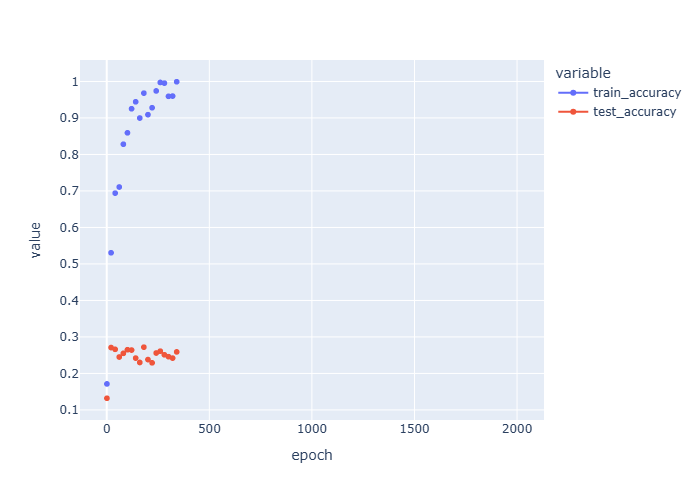

In [12]:
fig = px.line(
    out,
    x="epoch",
    y=["train_accuracy", "test_accuracy"],
    markers=True,
)

fig.show()

In [13]:
def plot_sharpness(metadata, output, model_id, include_eos_threshold=True):
    # filter model_id
    metadata = metadata[metadata['model_id']==model_id]
    output = output[output['model_id']==model_id]
    
    # metrics
    optimizer = metadata['optimizer'].iloc[0]
    learning_rate = metadata['learning_rate'].iloc[0]
    criterion = metadata['criterion'].iloc[0]

    # figure creation
    fig = px.scatter(output, x='epoch', y='sharpness_H', 
                     labels={
                         "epoch": "Epoch",
                         "sharpness_H": "Sharpness",
                     },
                     title=f"Sharpness of {optimizer} training with {learning_rate} learning rate and {criterion} criterion")
    
    if include_eos_threshold:
        fig.add_hline(y=2 / learning_rate, line_dash="dash", line_color="red")
    
    return fig

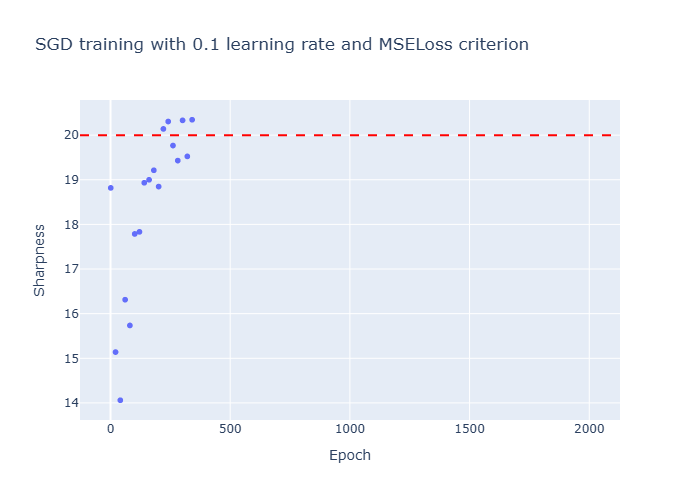

In [14]:
plot_sharpness(metadata=md, output=out, model_id=11)

In [30]:
def plot_accuracy(metadata, output, model_id, include_eos_threshold=True):
    # filter model_id
    metadata = metadata[metadata['model_id']==model_id]
    output = output[output['model_id']==model_id]

    # metametrics
    optimizer = metadata['optimizer'].iloc[0]
    learning_rate = metadata['learning_rate'].iloc[0]
    criterion = metadata['criterion'].iloc[0]

    # figure creation
    fig = px.scatter(output, x='epoch', y=['train_accuracy', 'test_accuracy'],
                     labels={
                         "epoch": "Epoch",
                         "train_accuracy": "Train Accuracy",
                         "test_accuracy": "Test Accuracy",
                         'value': 'Accuracy',
                     },
                     title=f"Accuracy of {optimizer} training with {learning_rate} learning rate and {criterion} criterion")

    return fig

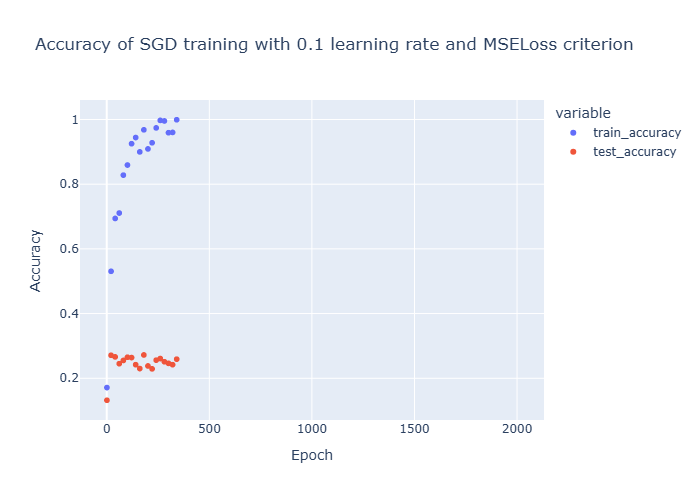

In [31]:
plot_accuracy(metadata=md, output=out, model_id=11)

# Multi-Model Tests

In [32]:
# Using the training params as above (minus lr)
epochs = 2000
accuracy = 0.999
model = models.FullyConnectedNet(
    input_size=input_size,
    num_hidden_layers=num_hidden_layers,
    hidden_layer_size=hidden_layer_size,
    num_labels=10,
    activation=nn.Tanh
)
criterion = nn.MSELoss()

# custom lr list
learning_rate_list = [0.05, 0.07, .1, .13, .15]
for lr in learning_rate_list:
    # Use optimizer with lr
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)
    
    # Train model
    fn.train_sgd_model(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        accuracy=accuracy,
        train_loader=train_loader,
        test_loader=test_loader,
        X=X,
        y=y,
        output_dir=output_dir
    )

Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.05. Took 541 epoches and 32.88 seconds. Final training accuracy: 0.9992; Final testing accuracy: 0.2570
Saved with model_id 15
Training FullyConnectedNet with SGD and learning rate 0.07 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.07. Took 141 epoches and 8.58 seconds. Final training accuracy: 0.9990; Final testing accuracy: 0.2400
Saved with model_id 16
Training FullyConnectedNet with SGD and learning rate 0.1 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.1. Took 101 epoches and 6.2 seconds. Final training accuracy: 0.9998; Final testing accuracy: 0.2590
Saved with model_id 17
Training FullyConnectedNet with SGD and learning rate 0.13 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.13. Took 61 epoches and 3.73 seconds. Final 

In [33]:
md, out = fn.load_output_files(output_dir)

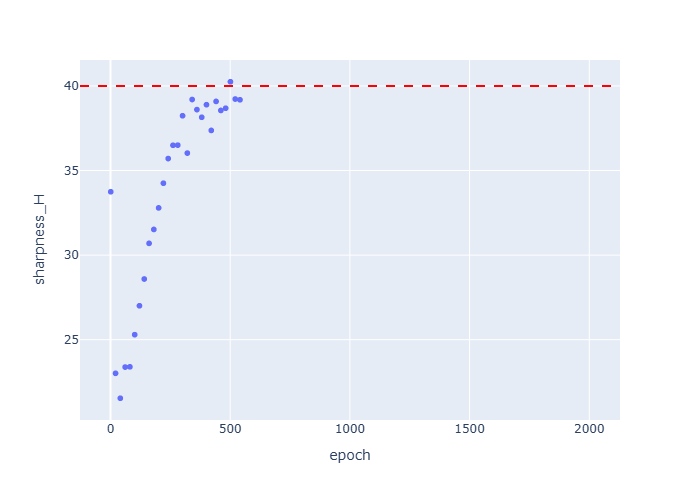

In [34]:
fig = px.scatter(out[out['model_id']==15], x='epoch', y='sharpness_H')
fig.add_hline(y=2/0.05, line_dash="dash", line_color="red")
fig.show()

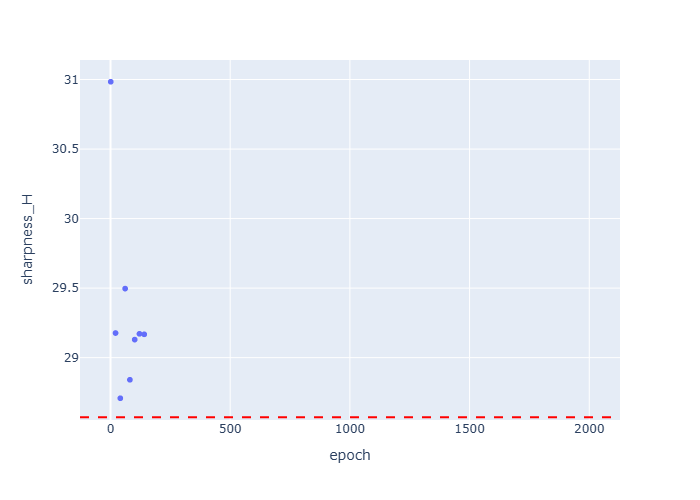

In [35]:
fig = px.scatter(out[out['model_id']==16], x='epoch', y='sharpness_H')
fig.add_hline(y=2/0.07, line_dash="dash", line_color="red")
fig.show()

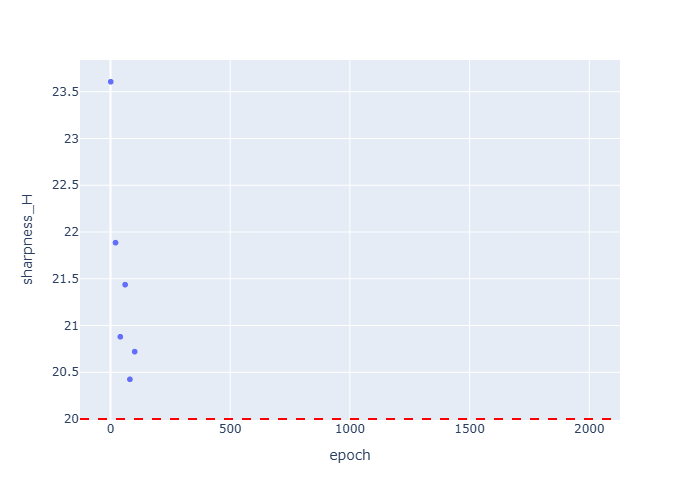

In [36]:
fig = px.scatter(out[out['model_id']==17], x='epoch', y='sharpness_H')
fig.add_hline(y=2/0.1, line_dash="dash", line_color="red")
fig.show()

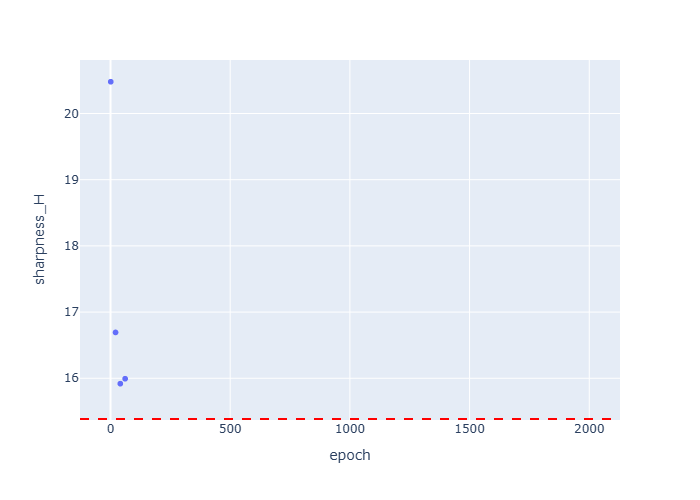

In [37]:
fig = px.scatter(out[out['model_id']==18], x='epoch', y='sharpness_H')
fig.add_hline(y=2/0.13, line_dash="dash", line_color="red")
fig.show()

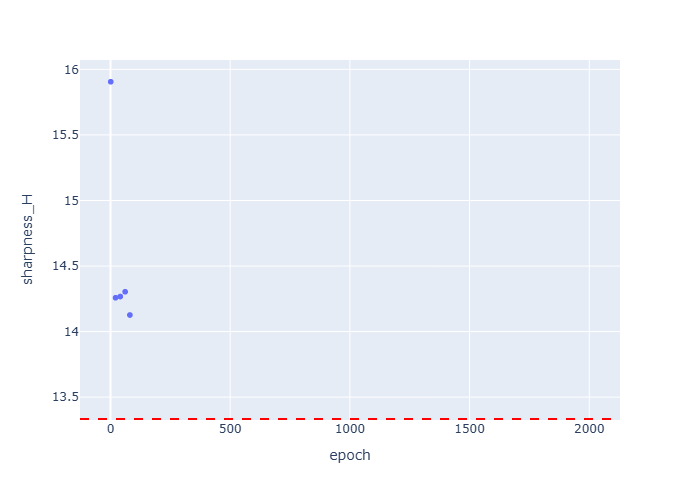

In [38]:
fig = px.scatter(out[out['model_id']==19], x='epoch', y='sharpness_H')
fig.add_hline(y=2/0.15, line_dash="dash", line_color="red")
fig.show()